## MINST and Fashion-MINST

In this notebook, we will use MNIST and FashionMNIST datasets from pytorch lilbrary. This data which will be trained using self-built model CNN.

In [0]:
# Importing the libraries
import torch
import torchvision
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# Transforms and load the datasets for train and test set data
data_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                     (0.5),(0.5))
                                    ])
train_data = FashionMNIST(root='./data', train=True, download=True, transform=data_transforms)
test_data = FashionMNIST(root='./data', train=False, download=True, transform=data_transforms)

batch_size = 20
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [0]:
classes = train_data.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize some training data

Let's visualize random image per one batch

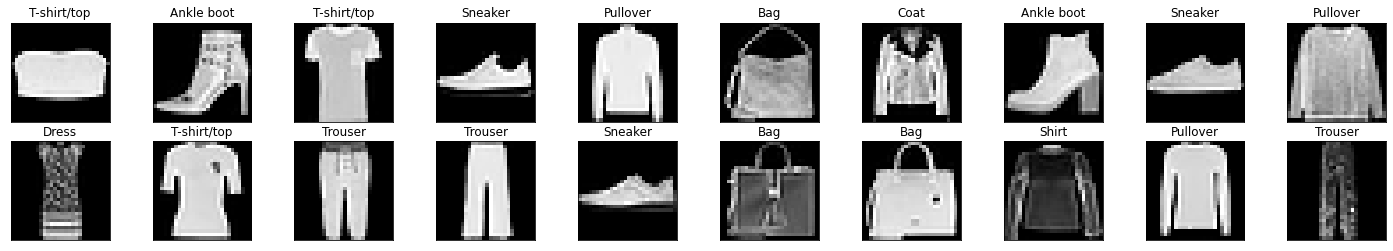

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

dataiter = iter(trainloader)
images,labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(batch_size):
    ax = plt.subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])
    

### Define the network

This network consists of two convolutionl layers and two hidden layers. You can make deep with add more convolutional layers along with the hidden layers.

Maxpool : Take the important features by extracting the maximum value in certain pixel in the feature vector. 

Drop : Disable certain node in the hidden layer with certain probbility value, we take p = 0.4


In [0]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64,10)

        self.drop = nn.Dropout(p=0.3)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return F.log_softmax(x,dim=1)

In [0]:
# Create the optimizer and loss 

import torch.optim as optim

net = CNN()
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.0001)

In [0]:
def train_net(model, trainloader, num_epoch=3, print_every=40):

    train_loss = 0.
    step = 0.
    ls = []
    for epoch in range(num_epoch):
        model.train()
        for image, label in trainloader:
            step += 1
            image = image.to(device)
            label = label.to(device)

            optimizer.zero_grad()

            output = model(image)
            loss = criterion(output,label)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if step % print_every == 0:
                ls.append(train_loss/print_every)

                print('Epoch : {}/{}..'.format(epoch+1,num_epoch),
                      'Train loss : {:.3f}..'.format(train_loss/print_every))
                
                train_loss = 0.

                model.train()
    print('Finished training')
    cache = {'model':model,'loss':ls}
    return cache

In [9]:
cache = train_net(net, trainloader, num_epoch=15, print_every=1000)

Epoch : 1/15.. Train loss : 1.328..
Epoch : 1/15.. Train loss : 0.788..
Epoch : 1/15.. Train loss : 0.699..
Epoch : 2/15.. Train loss : 0.643..
Epoch : 2/15.. Train loss : 0.596..
Epoch : 2/15.. Train loss : 0.582..
Epoch : 3/15.. Train loss : 0.548..
Epoch : 3/15.. Train loss : 0.535..
Epoch : 3/15.. Train loss : 0.521..
Epoch : 4/15.. Train loss : 0.491..
Epoch : 4/15.. Train loss : 0.503..
Epoch : 4/15.. Train loss : 0.479..
Epoch : 5/15.. Train loss : 0.467..
Epoch : 5/15.. Train loss : 0.458..
Epoch : 5/15.. Train loss : 0.454..
Epoch : 6/15.. Train loss : 0.437..
Epoch : 6/15.. Train loss : 0.437..
Epoch : 6/15.. Train loss : 0.422..
Epoch : 7/15.. Train loss : 0.412..
Epoch : 7/15.. Train loss : 0.418..
Epoch : 7/15.. Train loss : 0.408..
Epoch : 8/15.. Train loss : 0.399..
Epoch : 8/15.. Train loss : 0.399..
Epoch : 8/15.. Train loss : 0.390..
Epoch : 9/15.. Train loss : 0.387..
Epoch : 9/15.. Train loss : 0.380..
Epoch : 9/15.. Train loss : 0.376..
Epoch : 10/15.. Train loss :

Text(0, 0.5, 'Loss')

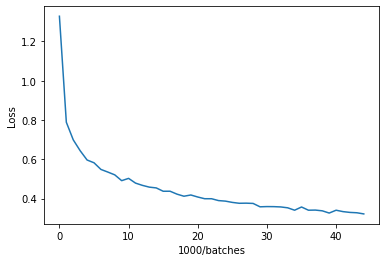

In [10]:
# Visualize the loss 
loss = cache['loss']

plt.plot(loss)
plt.xlabel('1000/batches')
plt.ylabel('Loss')

In [0]:
def validation(model, testloader, classes, batch_size):
    test_loss = 0.
    accuracy = 0.
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    model.eval()

    with torch.no_grad():
        for image, label in testloader:
            image = image.to(device)
            label = label.to(device)

            output = model(image)
            test_loss += criterion(output,label).item()

            ps = torch.exp(output)
            eq = (label.data == ps.max(dim=1)[1])
            for i in range(batch_size):
                lb = label.data[i]
                class_correct[lb] += eq[i].item()
                class_total[lb] += 1

    for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    for i in range(len(classes)):
      class_correct[i] = class_correct[i]/class_total[i]

    return class_correct


In [12]:
model = cache['model']

correct = validation(model, testloader, classes, batch_size)

Test Accuracy of T-shirt/top: 88% (5297/6000)
Test Accuracy of Trouser: 97% (5876/6000)
Test Accuracy of Pullover: 80% (4851/6000)
Test Accuracy of Dress: 90% (5433/6000)
Test Accuracy of  Coat: 87% (5254/6000)
Test Accuracy of Sandal: 97% (5823/6000)
Test Accuracy of Shirt: 67% (4078/6000)
Test Accuracy of Sneaker: 95% (5729/6000)
Test Accuracy of   Bag: 97% (5870/6000)
Test Accuracy of Ankle boot: 97% (5833/6000)

Test Accuracy (Overall): 90% (54044/60000)


In [0]:
def visualize_accuracy(correct, classes):

    fig, ax = plt.subplots(figsize=(10,12))
    ax.set_aspect(0.05)
    ax.barh(np.arange(10), correct, align='center')
    ax.set_yticks(np.arange(10))
    ax.set_yticklabels(classes, size='medium')
    ax.invert_yaxis()
    ax.set_xlabel('Class probability', fontsize='medium')
    ax.set_xlim(0, 1.)
    ax.set_title('Validation accuracy for each class')
    plt.tight_layout()


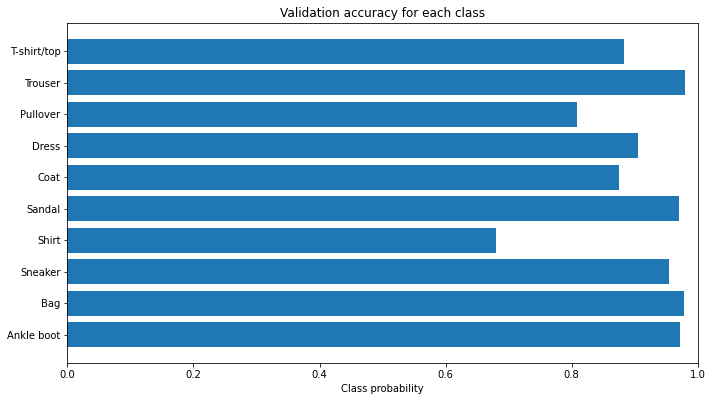

In [14]:
visualize_accuracy(correct,classes)

In [0]:
def visualize_image():
    model.eval()

    image, label = iter(testloader).next()
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
    ps = torch.exp(output)
    ps = ps.max(dim=1)[1]
    image = image.cpu().numpy()

    fig = plt.figure(figsize=(25,4))
    for idx in np.arange(batch_size):
        ax = plt.subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title("{} ({})".format(classes[ps[idx]], classes[label[idx]]),
                    color=("green" if ps[idx]==label[idx] else "red"))

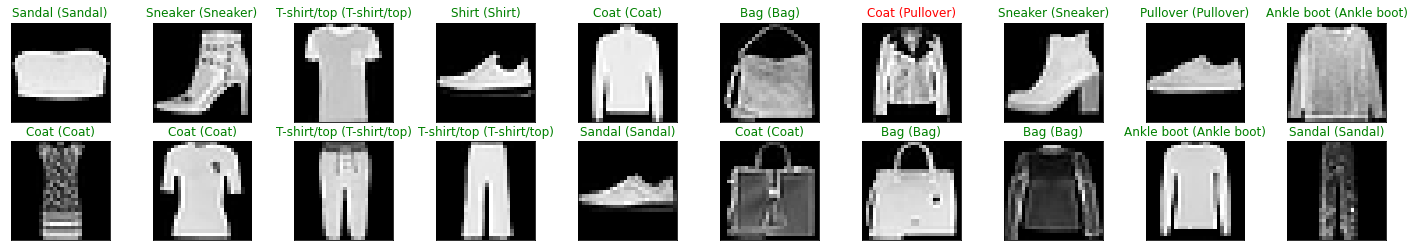

In [16]:
visualize_image()